In [147]:
from skimage.io import imread
import matplotlib.pyplot as plt
import maxflow
import numpy as np
import skimage

import useful as us

In [148]:
def segmentation_histogram(ax, I, S, edges=None):
    '''
    Histogram for data and each segmentation label.
    '''
    if edges is None:
        edges = np.linspace(I.min(), I.max(), 100)
    ax.hist(I.ravel(), bins=edges, color = 'k')
    centers = 0.5 * (edges[:-1] + edges[1:])
    for k in range(S.max() + 1):
        ax.plot(centers, np.histogram(I[S==k].ravel(), edges)[0])

# Prior, likelihood and posterior energy (no normalization)

In [162]:
# Data directory
data_dir = 'data_2021/'

In [166]:
# Open the image
I = skimage.io.imread(f'{data_dir}bony.png')

# Other parameters
mean = np.array([130, 190])
beta = 3000

In [167]:
# Perform the max likelihood segmentation
U = (I.reshape(I.shape+(1,)) - mean.reshape(1,1,-1))**2
S0 = np.argmin(U, axis=2)

In [168]:
# Calculate the prior energy
prior = beta * ((S0[:-1, :] != S0[1:, :]).sum() + (S0[:, :-1] != S0[:, 1:]).sum())
print(f'Prior energy: {prior}')

# Calculate the likelihood energy
likelihood = np.sum((mean[S0] - I)**2)
print(f'Likelihood energy: {likelihood}')

# Posterior energy
posterior = prior + likelihood
print(f'Posterior energy: {posterior}')

Prior energy: 18444000
Likelihood energy: 20344061
Posterior energy: 38788061


In [169]:
g = maxflow.Graph[float]()
nodeids = g.add_grid_nodes(I.shape)
g.add_grid_edges(nodeids, beta)
g.add_grid_tedges(nodeids, U[:,:,1], U[:,:,0])
g.maxflow()
S = g.get_grid_segments(nodeids)
print(f'Maximun a posteriori solution: {S.sum()}')

Maximun a posteriori solution: 5810


# Max likelihood classification (normalized)

In [153]:
# Data directory
data_dir = 'data_week5/'

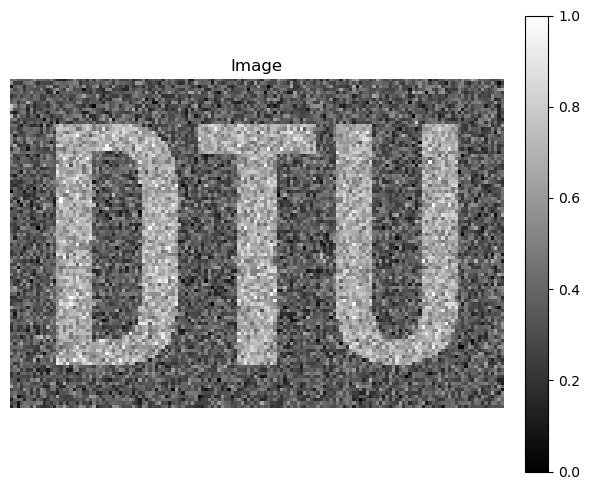

In [154]:
# Open the image
# I = skimage.io.imread(f'{data_dir}V12_10X_x502.png')/(2**16-1)
I = skimage.io.imread(f'{data_dir}DTU_noisy.png')/(255)

# Parameters
mean = np.array([90/255, 170/255])
beta = 0.1

# Display the image
us.display_images([I], ['Image'])

In [155]:
# Perform the max likelihood segmentation
U = np.stack([(I-mean[i])**2 for i in range(len(mean))], axis=2)
S0 = np.argmin(U, axis=2)

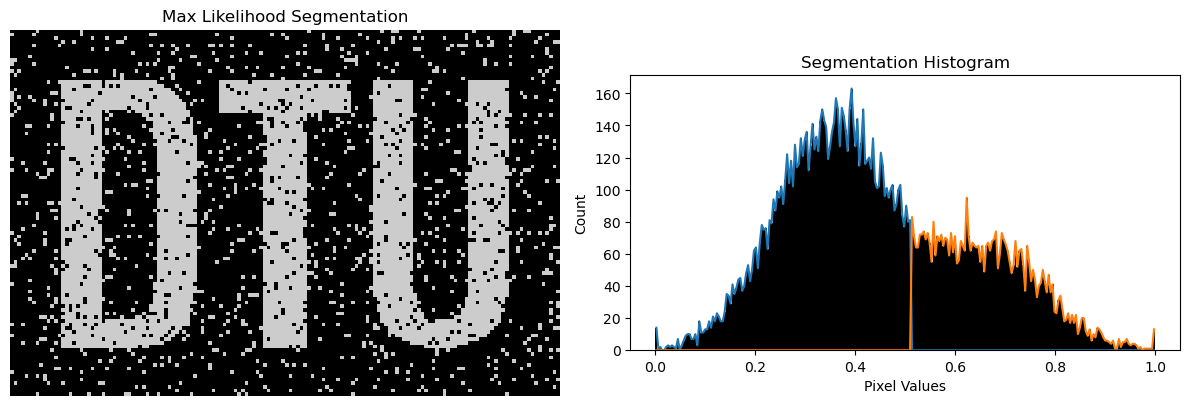

In [156]:
# Visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display the segmentation result
ax[0].imshow(S0, cmap='nipy_spectral')
ax[0].set_title('Max Likelihood Segmentation')
ax[0].axis('off')

# Create the segmentation histogram
edges = np.linspace(0, 1, 257)
segmentation_histogram(ax[1], I, S0, edges=edges)
ax[1].set_aspect(0.5 / ax[1].get_data_ratio())
ax[1].set_xlabel('Pixel Values')
ax[1].set_ylabel('Count')
ax[1].set_title('Segmentation Histogram')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Smallest posterior energy

In [157]:
import maxflow

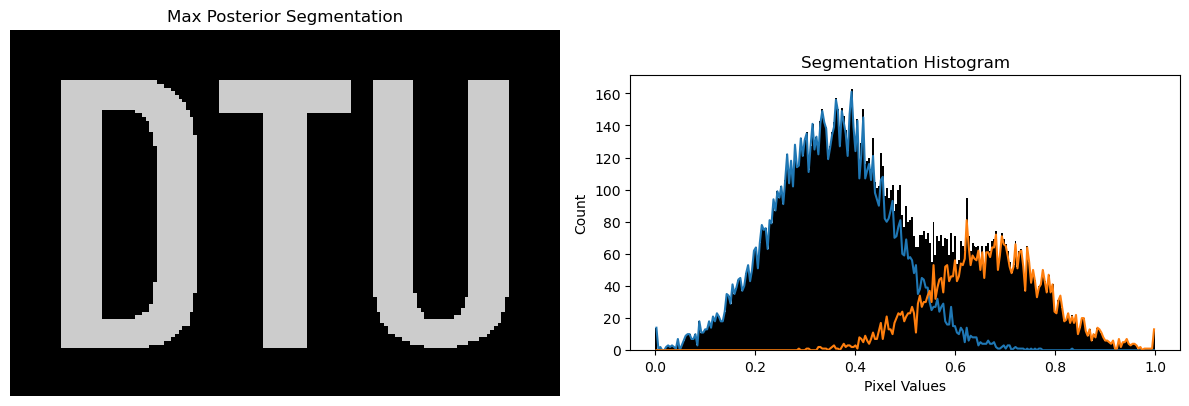

Maximun a posteriori solution: 4496


In [158]:
# Create a maxflow graph
g = maxflow.Graph[float]()  # Initialize a graph with float capacities

# Add nodes to the graph corresponding to each pixel in the image
nodeids = g.add_grid_nodes(I.shape)

# Add edges between 4-neighbor pixels with the specified beta weight
g.add_grid_edges(nodeids, beta)

# Add terminal edges (edges to source and sink) using the precomputed data cost U
# U[..., 1] represents the cost to connect each pixel to the sink
# U[..., 0] represents the cost to connect each pixel to the source
g.add_grid_tedges(nodeids, U[..., 1], U[..., 0])

# Solve the maxflow problem
g.maxflow()

# Obtain the segmentation result from the graph
S = g.get_grid_segments(nodeids)

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display the segmentation result
ax[0].imshow(S, cmap='nipy_spectral')
ax[0].set_title('Max Posterior Segmentation')
ax[0].axis('off')

# Create the segmentation histogram
segmentation_histogram(ax[1], I, S, edges=edges)
ax[1].set_aspect(0.5 / ax[1].get_data_ratio())
ax[1].set_xlabel('Pixel Values')
ax[1].set_ylabel('Count')
ax[1].set_title('Segmentation Histogram')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Calculate the posterior energy
print(f'Maximun a posteriori solution: {S.sum()}')


# Prior energy from a matrix

In [170]:
I = np.array([[1, 1, 1, 1, 2, 2, 2],
              [1, 2, 2, 1, 2, 3, 2],
              [2, 3, 2, 1, 2, 3, 2],
              [2, 2, 2, 1, 1, 3, 2],
              [1, 2, 1, 1, 1, 1, 1,]]) 

U2 = 10*(np.abs(np.diff(I, axis=0)).sum() + np.abs(np.diff(I, axis=1)).sum())
print(f'Prior energy: {U2}')

Prior energy: 300


# For gender labeling

In [159]:
import maxflow
import numpy as np
import matplotlib.pyplot as plt

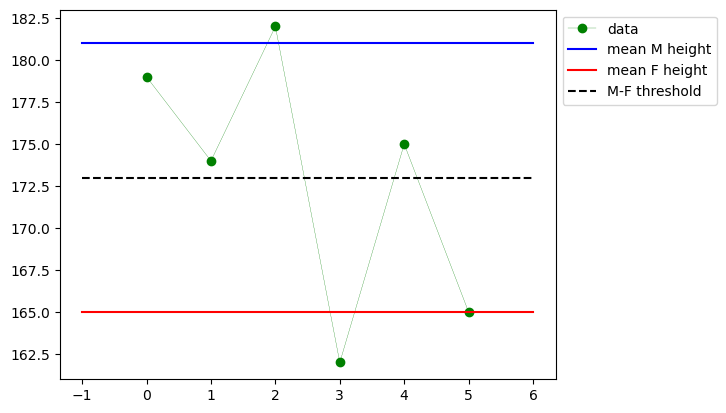

In [160]:
d = np.array([179, 174, 182, 162, 175, 165]) # heights (data term)

mu = [181, 165] # means of two classes, used for computation of likelihood
w_s = (d - mu[0]) ** 2 # source weight
w_t = (d - mu[1]) ** 2 # sink weights

fig, ax = plt.subplots()
ax.plot(d, '-og', lw=0.2, label='data')
ax.plot([-1, len(d)], [mu[0]]*2, 'b', label='mean M height')
ax.plot([-1, len(d)], [mu[1]]*2, 'r', label='mean F height')
ax.plot([-1, len(d)], [0.5*(mu[0] + mu[1])]*2, '--k', label='M-F threshold')
ax.legend(bbox_to_anchor = (1, 1))
plt.show()

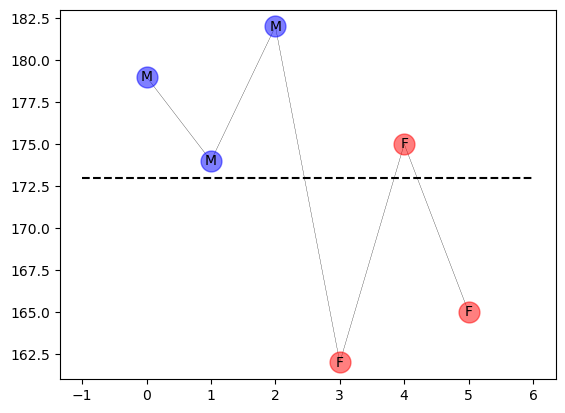

In [161]:
beta = 500  # try changing between 0 and 1000

# Create a graph with integer capacities.
g = maxflow.Graph[int]()

# Add (non-terminal) nodes and retrieve an index for each node.
nodes = g.add_nodes(len(d))

# Create edges between nodes.
for i in range(len(d)-1):
    g.add_edge(nodes[i], nodes[i+1], beta, beta)

# Set the capacities of the terminal edges.
for i in range(len(d)):
    g.add_tedge(nodes[i], (d[i] - mu[1]) ** 2, (d[i] - mu[0]) ** 2)

# Run the max flow algorithm.
flow = g.maxflow()

# Get the result as integer labels.
labeling = [g.get_segment(n) for n in nodes]

# Visualize
fig, ax = plt.subplots()
ax.plot([-1, len(d)], [0.5*(mu[0] + mu[1])]*2, '--k')
ax.plot(d, '-k', lw=0.2)
for i, di in enumerate(d):
    color = 'b' if labeling[i] == 0 else 'r'
    letter = 'M' if labeling[i] == 0 else 'F'
    ax.plot(i, di, 'o', color=color, alpha=0.5, markersize=15)
    ax.text(i, di, letter, ha='center', va='center')
plt.show()  